This is a **Digital Optical Character Reader** to read characters from text present in an image and display it. First it selects the region of text, crops the image, selects each line of text, and each word from each line, each letter from each word and predicts the character using a trained neural network.

(This OCR works for images with good contrast between the text and background, and where the text is quite dark. Working on an improvement on this)

Characters in the dataset are: **a-z, A-Z, 0-9**

In [1]:
import numpy as np
import cv2
from PIL import Image
import scipy.misc
import getWord
import matplotlib.pyplot as plt

Detect the edges between text and background using canny edge detection algorithm.

In [2]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

Increase contrast of image to make clear separation between text(dark) and background

In [3]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

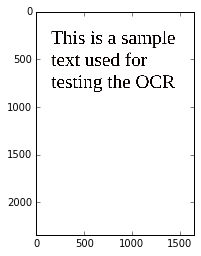

In [4]:
image = cv2.imread("paraSample.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# apply Canny edge detection using a wide threshold, tight
# threshold, and automatically determined threshold
auto = auto_canny(blurred)

# show the images
# cv2.imshow("Original", image)
# cv2.imshow("Canny", auto)
# cv2.waitKey(0)
plt.imshow(image, cmap='gray')
plt.show()

Dilate the text edges detected to get an idea of the area of text present in the image and crop it from the image

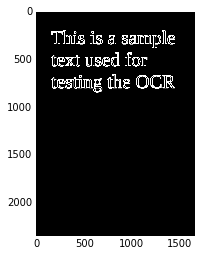

In [5]:
kernel = np.ones((8,8), np.uint8)  #can change value of 10 later

# The first parameter is the original image,
# kernel is the matrix with which image is 
# convolved and third parameter is the number 
# of iterations, which will determine how much 
# you want to erode/dilate a given image. 
img_dilation = cv2.dilate(auto, kernel, iterations=1)

#cv2.imshow('Input', auto)
# cv2.imshow('Dilation', img_dilation) 
# cv2.waitKey(0)
plt.imshow(img_dilation, cmap='gray')
plt.show()

In [6]:
img2= img_dilation
print('dimensions of the image is : ',img2.shape)

#the image is a numpy array
m , n = img2.shape
print(m)
print(n)

('dimensions of the image is : ', (2339, 1653))
2339
1653


Crop the text region

topmost row with white = 202
bottommost row with white = 851
leftmost row with white = 156
rightmost row with white = 1448


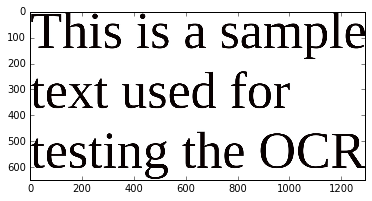

In [7]:
# 0 is for black, 255 is white
# save the top, left, right, bottom most white points

#topmost
flg=0

for i in range(0,m):
    for j in range(0,n):
        if img2[i][j]==255:
            top=i
            flg=1
            break
    if flg==1:
        break		

print('topmost row with white = '+str(top))

#bottommost , start checking from bottom so that middle black lines not skipped
flg=0
for i in range(m-1,top,-1):
    for j in range(0,n):
        if img2[i][j]==255:
            bot=i
            flg=1
            break
    if flg==1:
        break;

print('bottommost row with white = '+str(bot))

#leftmost
flg=0
for j in range(0,n):
    for i in range(0,m):
        if img2[i][j]==255:
            lft=j
            flg=1
            break
    if flg==1:
        break		
print('leftmost row with white = '+str(lft))

#rightmost
flg=0
for j in range(n-1,lft,-1):
    for i in range(0,m):
        if img2[i][j]==255:
            flg=1
            ryt=j;
            break
    if flg==1:
        break;

print('rightmost row with white = '+str(ryt))

#CROP the image
crop_img = image[top:bot, lft:ryt]
plt.imshow(crop_img, cmap='gray')
plt.show()

In [8]:
scipy.misc.imsave('bwsample.jpg', crop_img)

Now, we separate the lines from the text image, then the words in a separate file getWord.py

In [9]:
#file to extract each line from the final cropped image and extract words from it
import os 
import numpy as np
import cv2
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
import getCharacter

In [10]:
def getBW(imgfile):
	#convert to pure black and white
	m,n=imgfile.shape
	for i in range(0,n):
		for j in range(0,m):
			if imgfile[j][i]<=128:
				imgfile[j][i]=0
			else:
				imgfile[j][i]=255	

	#display after B&W full once
	# cv2.imshow("The Black and White image", imgfile)
	# cv2.waitKey(0)

	plt.imshow(imgfile, cmap='gray')
	plt.show()
	return imgfile

<type 'numpy.ndarray'>
(649, 1292, 3)
(649, 1292)


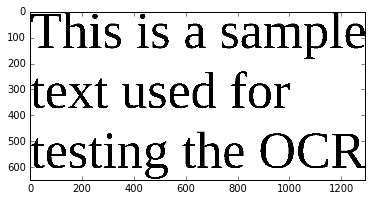

In [11]:
imgfile = cv2.imread("bwsample.jpg")

print(type(imgfile))
print(imgfile.shape)

#convert from 3d to 2d
imgfile=imgfile[:,:,0]
print(imgfile.shape)

m,n=imgfile.shape

#create a black and white copy of image file
imgfile=getBW(imgfile)

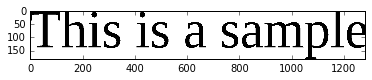

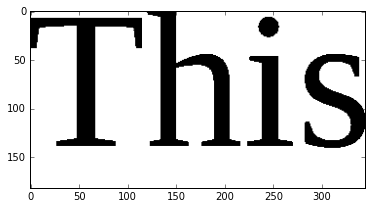

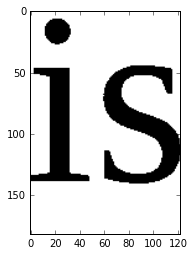

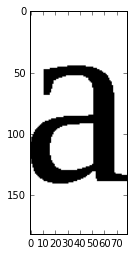

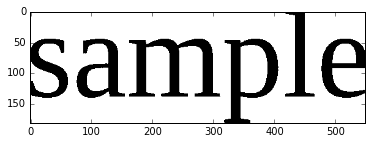

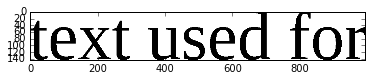

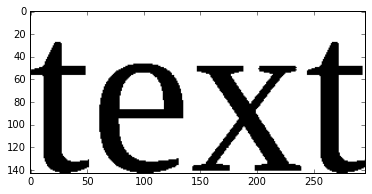

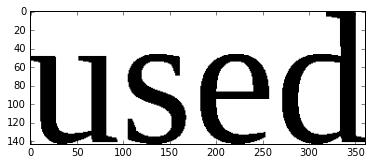

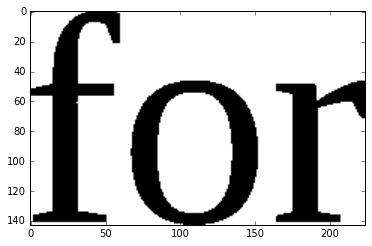

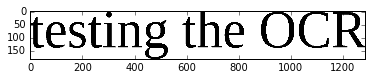

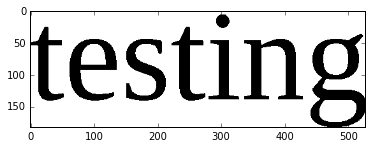

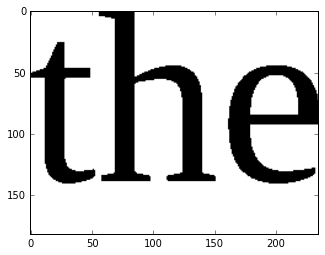

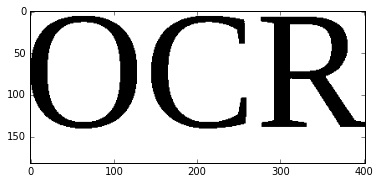

In [14]:
#get each line
#search for first black point, save as start, continue till not all white, if no strt found, its over
#0 is black
linei=0
mywordval=0
while True:
    strt=-1
    lst=-1
    while linei!=m:
        for linej in range(0,n):
            if imgfile[linei][linej]==0:
                strt=linei;
                break;
        if strt!=-1:
            break
        linei=linei+1
    if linei==m:   #or strt!=-1
        break;
    #now find end of line
    while linei!=m:
        flag=1
        for j in range(0,n):
            if imgfile[linei][j]==0:
                flag=0;
                break;
        if flag==1: # all white means end of line
            lst=linei
            break
        linei=linei+1

    #got the lines, now get the words

    thisline=imgfile[strt:lst, 0:n]
    matx, maty=thisline.shape	

    #trim the right side of white space from each line

    #from right
    flag11=0
    rmargin=0
    for y in range(maty-1,0,-1):
        for x in range(0,matx):
            if thisline[x][y]==0:
                flag11=1;
                rmargin=y
                break
        if flag11==1:
            break;

    #from left
    flag11=0
    lmargin=0
    for y in range(0,maty):
        for x in range(0,matx):
            if thisline[x][y]==0:
                flag11=1;
                lmargin=y
                break
        if flag11==1:
            break;

    thisline=thisline[:,lmargin:rmargin]






    # print("Now we need to divide words in this line")
    matx, maty=thisline.shape	
    # print('The shape of this line is : '+str(matx)+' by '+str(maty))

    plt.imshow(thisline, cmap='gray')
    plt.show()


    threshold= 35  #words are separated by at least 35 pixels
    #bg, ed
    wordbg=0
    i2=0
    thelast=maty-threshold-1
    while True:
        if i2==thelast:
            break;
        #print('start i2='+str(i2))
        #check threshold square/rectangle for all white,if yes, the it is separator / SLIDE a rectangle to find spaces
        flag=1
        for i in range(i2,i2+threshold):
            for j in range(0,matx):
                if thisline[j][i]==0:
                    flag=0
                    break
            if flag==0:
                break
        if flag==1:
            wordend=i2
            #print('word from '+str(wordbg)+' to '+str(wordend))
            thisword=thisline[0:matx,wordbg:wordend]
            plt.imshow(thisword, cmap='gray')
            plt.show()

            i2=i2+threshold
            #start i2 again from next word
            while True:
                flag2=1
                for i in range(0,matx):
                    if thisline[i][i2]==0:
                        flag2=0
                        break
                if flag2==0:
                    break;
                i2+=1
            wordbg=i2
        i2+=1
        if i2==thelast:
            #print('the last word of this line is ')
            lastword=thisline[0:matx,wordbg:maty]
            plt.imshow(lastword, cmap='gray')
            plt.show()
            break;

        mywordval+=1

    print('\n')
    # print('one line of words complete, next line\n\n')

Explaining the getCharacter.py file using one of the words 'sample' .  

In [15]:
#file to extract each character from a word, PAD it to form a square
import numpy as np
import cv2
import os
from PIL import Image
import scipy.misc
from scipy.misc import imresize
import matplotlib.pyplot as plt

In [17]:
def sigmoid(z):
	tmp2=1.0+np.exp(-z)
	g=1.0 / tmp2
	return g 

def predictChar(theta1, theta2, X):
	X=X.ravel()
	X=X.reshape((1,X.shape[0]))
	#print(X.shape)
	m,n=X.shape
	X=(X * 1.0)/255.0

	a1=X
	a1=np.hstack((np.ones((m,1)),a1))
	z2=a1.dot(theta1.T)
	a2=sigmoid(z2)

	m2,n2=a2.shape
	a2=np.hstack((np.ones((m2,1)),a2))
	hx=a2.dot(theta2.T)
	hx=sigmoid(hx)

	pr=np.argmax(hx,axis=1)

	#print(pr)
	return (pr[0]+1)

In [18]:
def convertBW(convimg):
	m,n=convimg.shape

	#convert to pure black and white
	for i in range(0,n):
		for j in range(0,m):
			if convimg[j][i]<=128:
				convimg[j][i]=0
			else:
				convimg[j][i]=255	
	return convimg

In [22]:
def trimAndPad(letter):
	myletter=letter
	myx,myy=myletter.shape
	#trim whites from all sides
	f=0 
	#top
	s1=0
	s2=0
	s3=0
	s4=0
	for i in range(0,myx):
		for j in range(0,myy):
			if myletter[i][j]==0:
				s1=i
				f=1
				break;
		if f==1:
			break

	f=0 
	#bottom
	for i in range(myx-1,0,-1):
		for j in range(0,myy):
			if myletter[i][j]==0:
				s2=i
				f=1
				break;
		if f==1:
			break

	f=0 
	#left
	for j in range(0,myy):
		for i in range(0,myx):
			if myletter[i][j]==0:
				s3=j
				f=1
				break;
		if f==1:
			break

	f=0 
	#right
	for j in range(myy-1,0,-1):
		for i in range(0,myx):
			if myletter[i][j]==0:
				s4=j
				f=1
				break;
		if f==1:
			break

	myletter=myletter[s1:s2, s3:s4]

	#now pad and make SQUARE
	myx,myy=myletter.shape
	if myx>myy: #height is more, pad left right
		diff=myx-myy
		half=diff/2
		sqletter = np.zeros(shape=(myx,myx))
		for i in range(0,myx):
			for j in range(0,myx):
				sqletter[i][j]=255

		for i in range(0,myx):
			for j in range(half,half+myy):
				sqletter[i][j]=myletter[i][j-half]
	else:
		diff=myy-myx
		half=diff/2
		sqletter = np.zeros(shape=(myy,myy))
		for i in range(0,myy):
			for j in range(0,myy):
				sqletter[i][j]=255

		for i in range(half,myx+half):
			for j in range(0,myy):
				sqletter[i][j]=myletter[i-half][j]

	myletter=sqletter
	myletter=imresize(myletter,[30,30])
	myletter=np.invert(myletter)
	#myletter=convertBW(myletter)
	# plt.imshow(sqletter, cmap='gray')
	# plt.show()
	return myletter

In [23]:
def getChar(dict, theta1, theta2, imgfile):

	#convert from 3d to 2d
	if imgfile.ndim==3:
		imgfile=imgfile[:,:,0]
	# print(imgfile.shape)


	# print("Now we need to divide letters in this word")
	matx, maty=imgfile.shape	

	#trim from right
	flag11=0
	rmargin=0
	for y in range(maty-1,0,-1):
		for x in range(0,matx):
			if imgfile[x][y]==0:
				flag11=1;
				rmargin=y
				break
		if flag11==1:
			break;

	#trim from left
	flag11=0
	lmargin=0
	for y in range(0,maty):
		for x in range(0,matx):
			if imgfile[x][y]==0:
				flag11=1;
				lmargin=y
				break
		if flag11==1:
			break;

	# print('lmargin rmargin are: ')
	# print(lmargin)
	# print(rmargin)

	imgfile=imgfile[:,lmargin:rmargin]

	matx, maty=imgfile.shape



	threshold= 2  #assume letters are separated by at least 2 pixels
	#bg, ed
	wordbg=0
	i2=0

	thelast=maty-threshold-1
	while True:
		if i2==thelast:
			break;
		
		flag=1
		for i in range(i2,i2+threshold):
			for j in range(0,matx):
				if imgfile[j][i]==0:
					flag=0
					break
			if flag==0:
				break
		if flag==1:
			wordend=i2
		#	print('letter from '+str(wordbg)+' to '+str(wordend))
			thisword=imgfile[0:matx,wordbg:wordend]
			thisword=trimAndPad(thisword)
			plt.imshow(thisword, cmap='gray')
			plt.show()
			letterval=predictChar(theta1,theta2,thisword)
			print dict[letterval],
			i2=i2+threshold
			#start i2 again from next word
			while True:
				flag2=1
				for i in range(0,matx):
					if imgfile[i][i2]==0:
						flag2=0
						break
				if flag2==0:
					break;
				i2+=1
			wordbg=i2
		i2+=1
		if i2==thelast:
			#print('the last letter of this line is from '+str(wordbg)+' to '+str(maty))
			lastword=imgfile[0:matx,wordbg:maty]
			lastword=trimAndPad(lastword)
			plt.imshow(lastword, cmap='gray')
			plt.show()
			letterval=predictChar(theta1,theta2,lastword)
			print dict[letterval],
			# scipy.misc.imsave('myword.jpg', lastword)
			break;
	return

In [ ]:
dict = {1: '0', 2: '1', 3: '2', 4: '3', 5:'4',6:'5',7:'6',8:'7',9:'8',10:'9',
        11:'A',12:'B',13:'C',14:'D',15:'E',16:'F',17:'G',18:'H',19:'I',20:'J',
        21:'K',22:'L',23:'M',24:'N',25:'O',26:'P',27:'Q',28:'R',29:'S',30:'T',
        31:'U',32:'V',33:'W',34:'X',35:'Y',36:'Z',37:'a',38:'b',39:'c',40:'d',
        41:'e',42:'f',43:'g',44:'h',45:'i',46:'j',47:'k',48:'l',49:'m',50:'n',
        51:'o',52:'p',53:'q',54:'r',55:'s',56:'t',57:'u',58:'v',59:'w',60:'x',
        61:'y',62:'z'}

theta1=np.load('neural_network/theta1.npy')
theta2=np.load('neural_network/theta2.npy')

# print(theta1.shape)
# print(theta2.shape)

getChar(dict, theta1, theta2,  img)

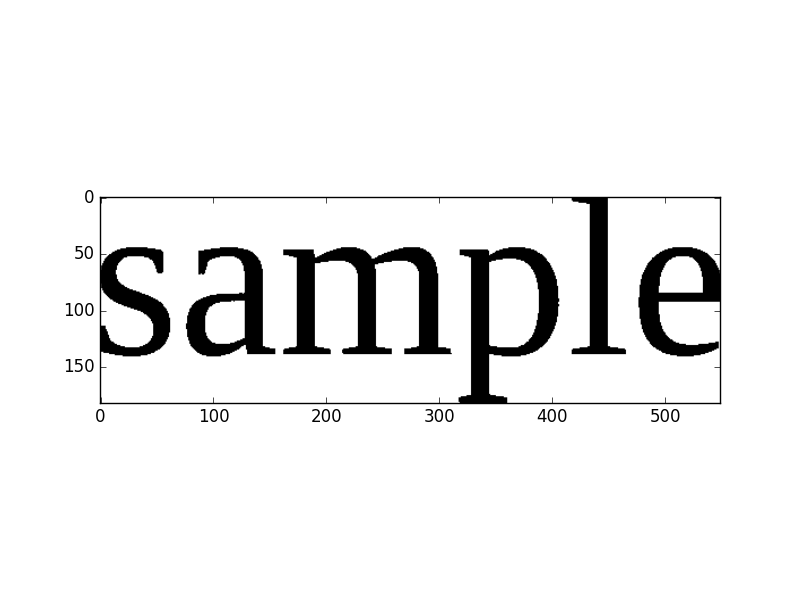

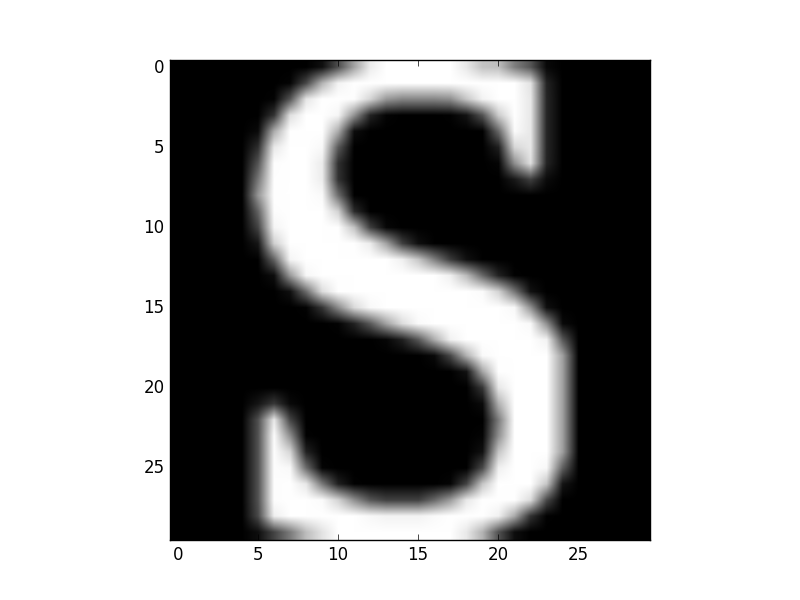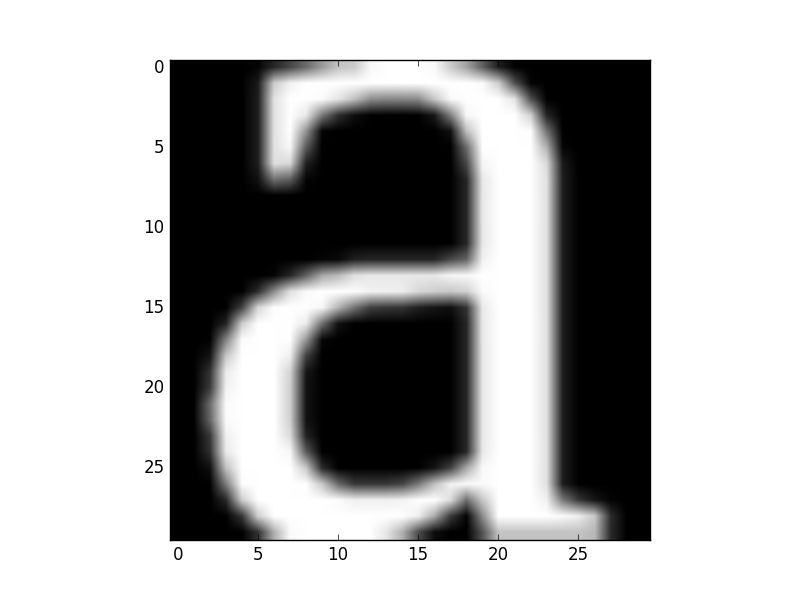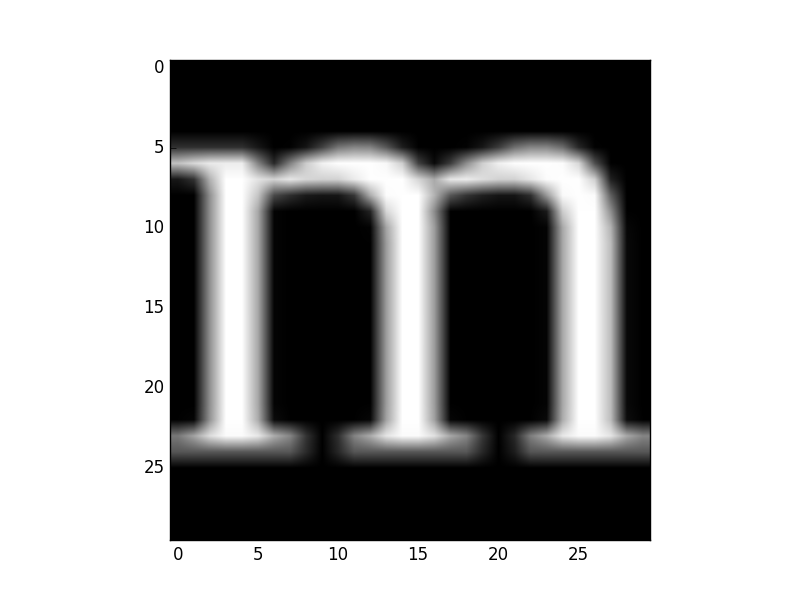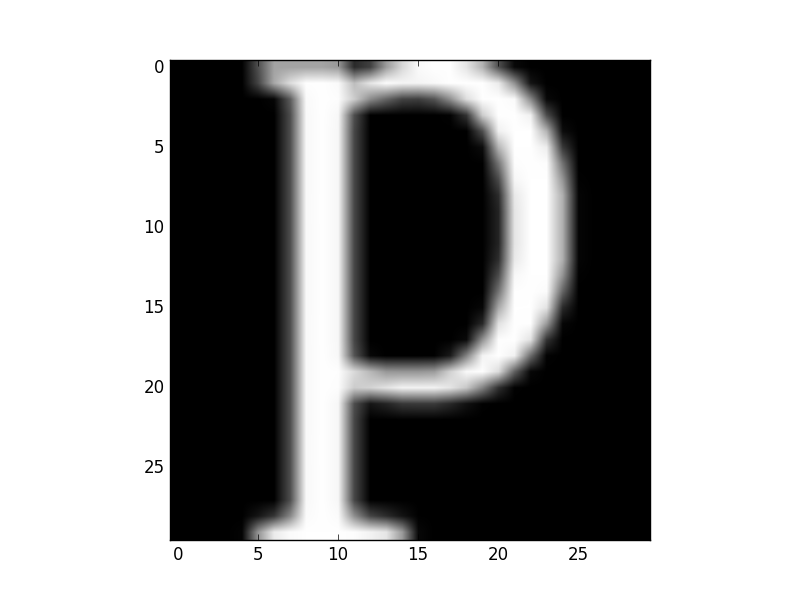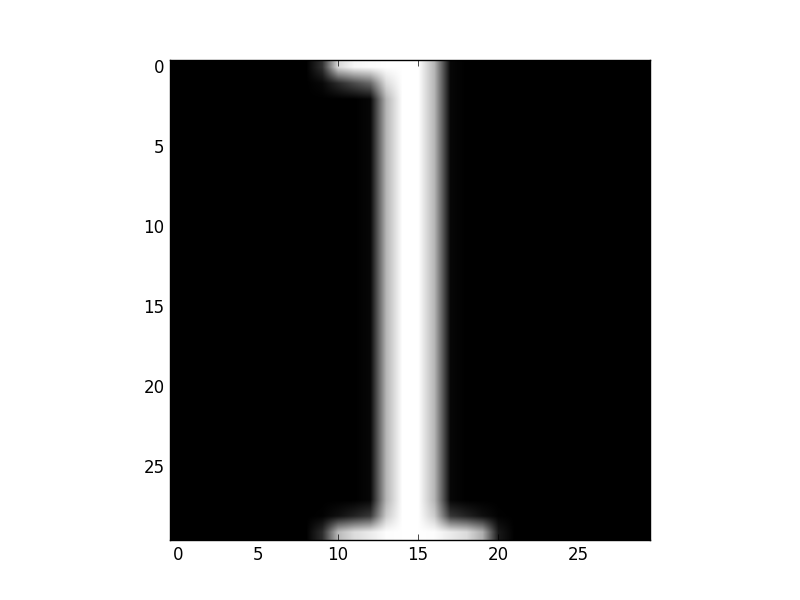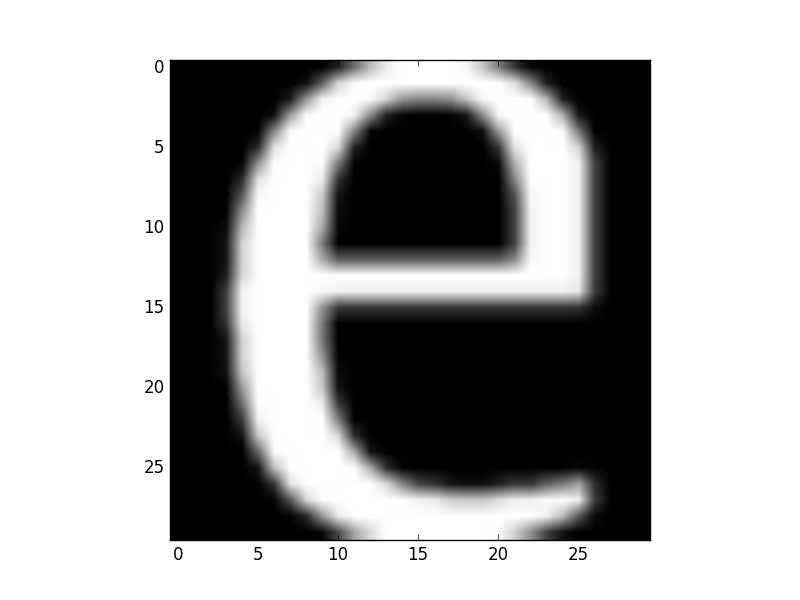

The output generated by the predict() function for the 'sample' image is S a m p l e . The S is capitalised because the trained neural network cannot differentiate between some cases of o and s where 30* 30 images of both look similar.
Hence , the full output of the program is:

T h i S      i S      a      S a m p l e      

t e X t      u S e d      f o r      

t e S t i n g      t h e      o C R   


which is pretty readable ignoring the capitalisations.